---
title : "Fragility Curve Overtopping"
excecute:
    output: asis
---

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
from toolbox_continu_inzicht.fragility_curves import (
    ChangeCrestHeightFragilityCurveOvertopping,
    FragilityCurveOvertopping,
    ShiftFragilityCurveOvertopping,
)

In [3]:
from toolbox_continu_inzicht.base.data_adapter import Config, DataAdapter

path = Path.cwd() / "data_sets"
config = Config(config_path=path / "test_fragility_curve_overtopping.yaml")
config.lees_config()
data_adapter = DataAdapter(config=config)

In [4]:
fragility_curve_overtopping = FragilityCurveOvertopping(data_adapter=data_adapter)
fragility_curve_overtopping.run(
    input=["slopes", "profiles", "bedlevel_fetch"],
    output="fragility_curves",
)

<Axes: xlabel='waterlevels'>

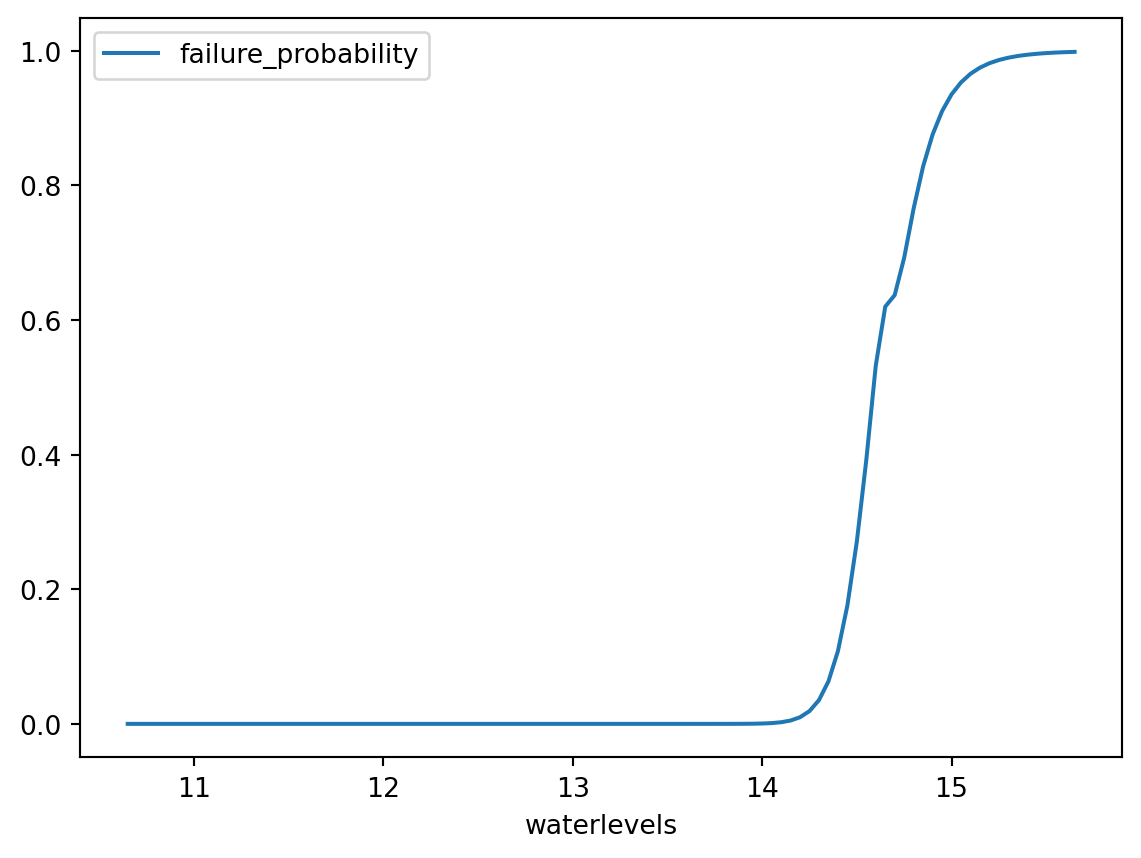

In [5]:
fragility_curve_overtopping.df_out.set_index("waterlevels").plot()

In [6]:
fragility_curve_overtopping.df_out

,waterlevels,failure_probability
0,10.65,0.000000
1,10.75,0.000000
2,10.85,0.000000
3,10.95,0.000000
4,11.05,0.000000
...,...,...
76,15.45,0.995540
77,15.50,0.996578
78,15.55,0.997358
79,15.60,0.997948


In [7]:
shift_fragility_curve_overtopping = ShiftFragilityCurveOvertopping(
    data_adapter=data_adapter
)

shift_fragility_curve_overtopping.run(
    input=["slopes", "profiles", "bedlevel_fetch"],
    output="fragility_curves",
    effect=0.5,
)

<Axes: xlabel='waterlevels'>

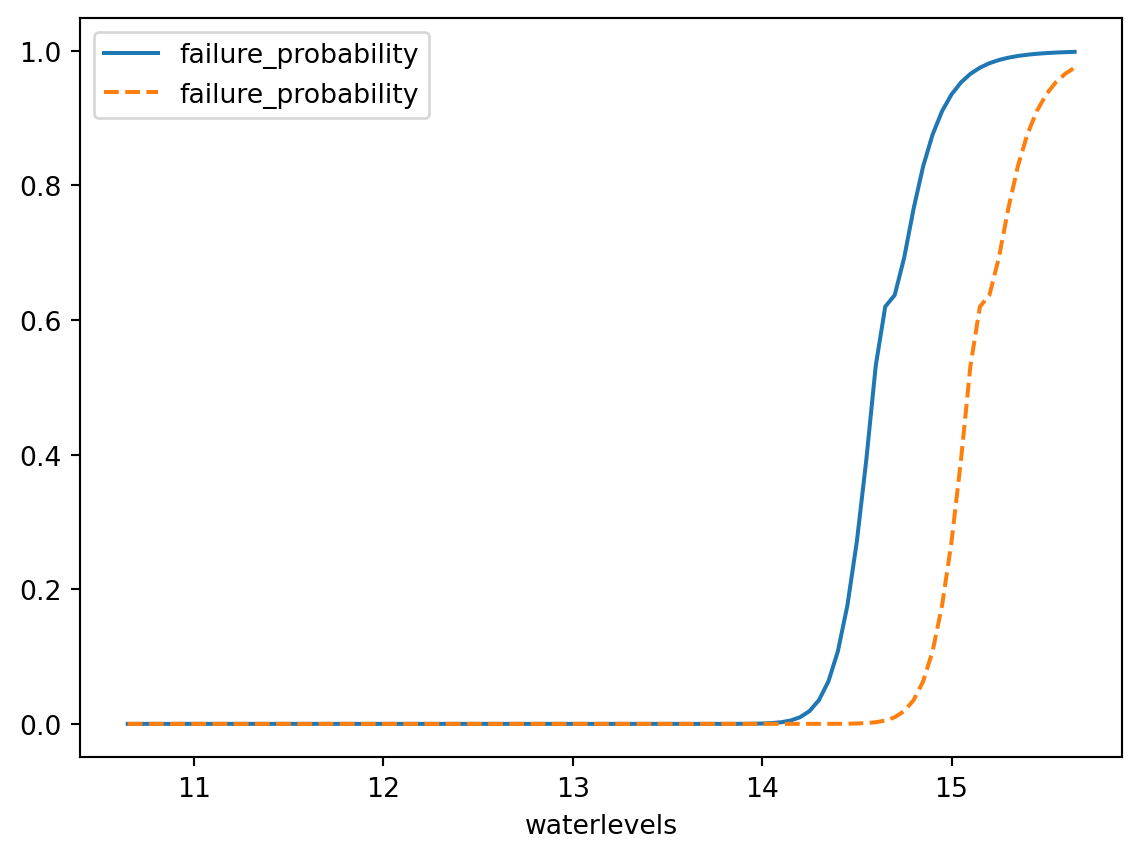

In [8]:
fig, ax = plt.subplots(1, 1)
fragility_curve_overtopping.df_out.set_index("waterlevels").plot(ax=ax)
shift_fragility_curve_overtopping.df_out.set_index("waterlevels").plot(
    ax=ax, linestyle="--"
)

In [9]:
change_crest_fragility_curve_overtopping = ChangeCrestHeightFragilityCurveOvertopping(
    data_adapter=data_adapter
)

change_crest_fragility_curve_overtopping.run(
    input=["slopes", "profiles", "bedlevel_fetch"],
    output="fragility_curves",
    effect=0.5,
)

<Axes: xlabel='waterlevels'>

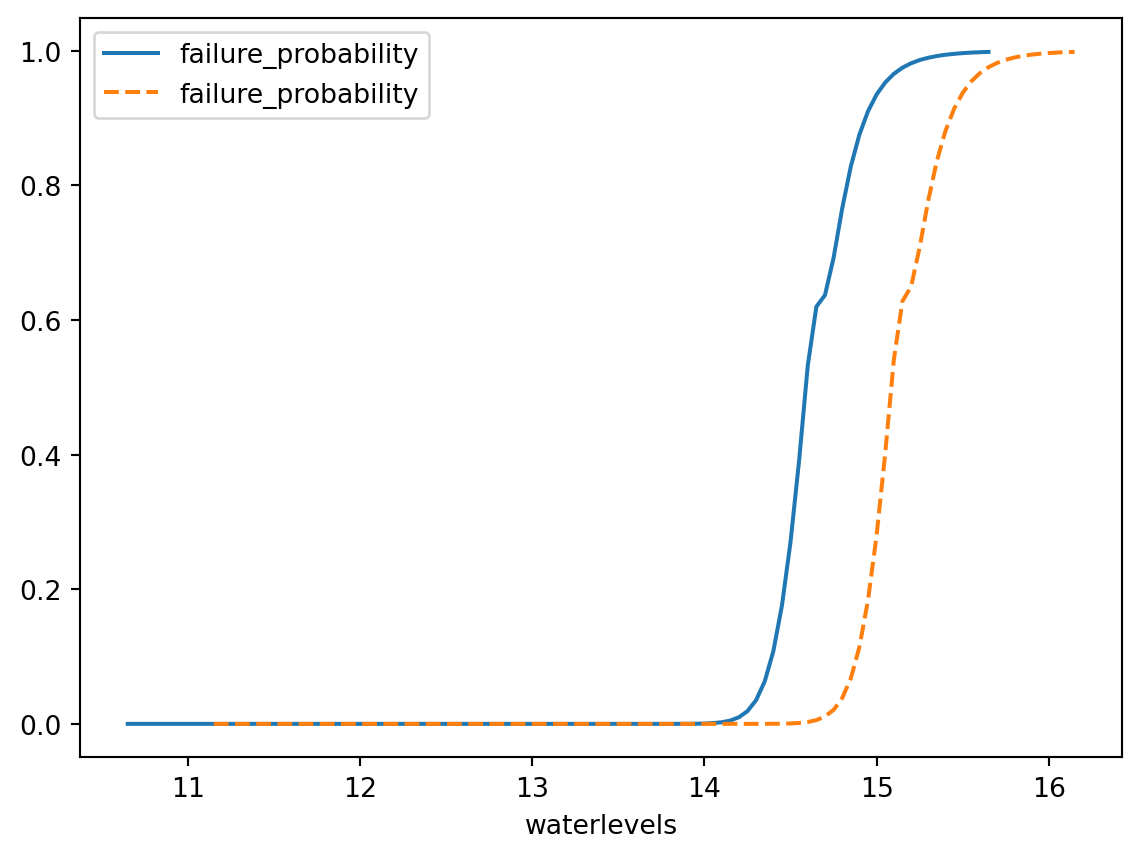

In [10]:
fig, ax = plt.subplots(1, 1)
fragility_curve_overtopping.df_out.set_index("waterlevels").plot(ax=ax)
change_crest_fragility_curve_overtopping.df_out.set_index("waterlevels").plot(
    ax=ax, linestyle="--"
)